In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import important libraries

In [3]:
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.4 MB/s eta 0:00:00


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import warnings
from scipy.stats import norm
import pickle

In [7]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

# Read preprocessed train data

In [247]:
X_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_train_preprocessed')
y_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_train_preprocessed')

# Read and transform test data

In [11]:
with open('/content/drive/MyDrive/Churn Prediction/test_pipeline.pkl', 'rb') as file:
    test_pipeline = dill.load(file)

In [248]:
X_test = test_pipeline.transform(pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_test'))
y_test = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_test')

# See data distribution on target variable

In [13]:
targets = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_train_preprocessed')

In [25]:
not_churned = targets[targets['target_event'] == 1]['target_actual_profit']
churned = targets[targets['target_event'] == 0]['target_actual_profit']

In [26]:
churned.describe()

,target_actual_profit
count,60303.000000
mean,-13.204207
std,0.092765
min,-13.587740
25%,-13.266680
50%,-13.204538
75%,-13.141362
max,-12.838961


In [27]:
not_churned.describe()

,target_actual_profit
count,60303.000000
mean,3.492639
std,5.108407
min,-0.203313
25%,0.981055
50%,2.074501
75%,4.173988
max,155.811700


Based on the visualizations, it is clear that churned customers exhibit a uniform profit value, while non-churned customers demonstrate significant variability in profit. Consequently, I will treat these two groups separately in my analysis. For the churned customers, I will assign a constant profit value that accurately reflects their impact on future revenue, as they do not contribute positively after exiting. In contrast, for non-churned customers, I will employ regression techniques to predict their potential profit based on their distinct characteristics. This differentiated approach allows for a more precise modeling strategy, ultimately leading to enhanced insights for developing effective retention strategies and optimizing profitability.

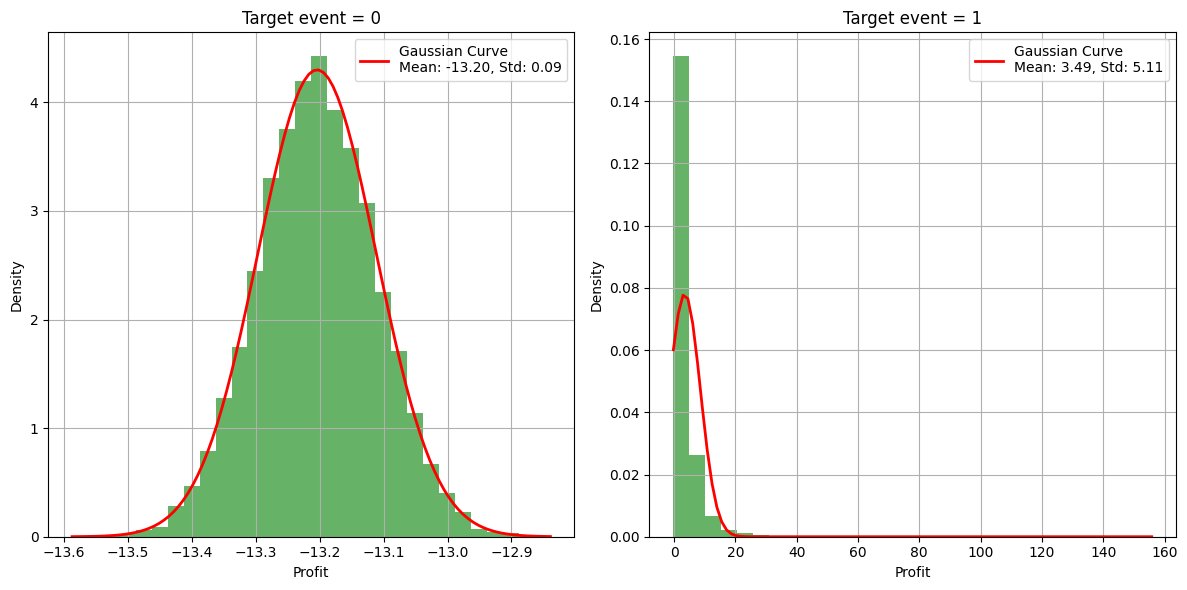

In [38]:
figure, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax = ax.flatten()

for i in range(2):
    data = targets[targets['target_event'] == i]['target_actual_profit']

    ax[i].hist(data, bins=30, density=True, alpha=0.6, color='g')
    mean = data.mean()
    std = data.std()

    x = np.linspace(data.min(), data.max(), 100)

    ax[i].plot(x, norm.pdf(x, mean, std), 'r-', lw=2, label=f'Gaussian Curve\nMean: {mean:.2f}, Std: {std:.2f}')

    ax[i].set_title(f'Target event = {i}')
    ax[i].set_xlabel('Profit')
    ax[i].set_ylabel('Density')
    ax[i].grid()
    ax[i].legend()

plt.tight_layout()
plt.show()

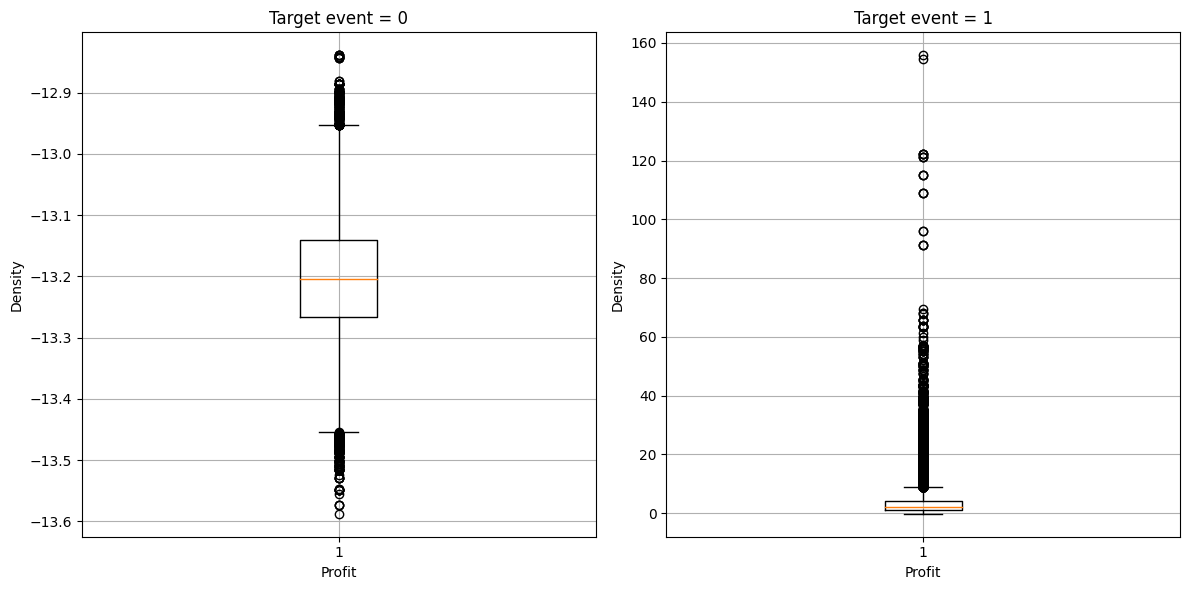

In [42]:
figure, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax = ax.flatten()

for i in range(2):
    data = targets[targets['target_event'] == i]['target_actual_profit']

    ax[i].boxplot(data)
    ax[i].set_title(f'Target event = {i}')
    ax[i].set_xlabel('Profit')
    ax[i].set_ylabel('Density')
    ax[i].grid(True)

plt.tight_layout()
plt.show()

 To effectively separate the data into churned and not churned customers, we can create a classification model that first identifies whether a customer has churned. In this case, churn is represented by a constant target value in the profit variable, indicating a lack of future transactions. The model will initially classify each customer as either churned or not. For customers identified as churned, we can assign a constant profit value, reflecting the loss incurred due to their exit. Conversely, for those not classified as churned, we will employ regression techniques to predict the actual profit they are expected to generate based on their characteristics. This dual approach ensures that we accurately capture the unique dynamics of churned customers while allowing for meaningful profit predictions for retained customers, ultimately enhancing our ability to inform retention strategies and optimize profitability.

In [253]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_train_churned = X_train[y_train['target_event'] == 0]
X_train_not_churned = X_train[y_train['target_event'] == 1]

y_train_churned = y_train[y_train['target_event'] == 0]
y_train_not_churned = y_train[y_train['target_event'] == 1]

In [279]:
X_train_not_churned.to_parquet('/content/drive/MyDrive/Churn Prediction/X_train_not_churned')
y_train_not_churned.to_parquet('/content/drive/MyDrive/Churn Prediction/y_train_not_churned')

In [254]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_test_churned = X_test[y_test['target_event'] == 0]
X_test_not_churned = X_test[y_test['target_event'] == 1]

y_test_churned = y_test[y_test['target_event'] == 0]
y_test_not_churned = y_test[y_test['target_event'] == 1]

In [280]:
X_test_churned.to_parquet('/content/drive/MyDrive/Churn Prediction/X_test_churned')
y_test_churned.to_parquet('/content/drive/MyDrive/Churn Prediction/y_test_churned')